In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import sys
from matplotlib.patches import Circle

%matplotlib inline

In [2]:
def interest_points_visualization(I_, kp_data_, ax=None):
    '''
    Plot keypoints chosen by detectos on image.
    Args:
        I_: Image (if colored, make sure it is in RGB and not BGR).
        kp_data_: Nx3 array, as described in assignment.
        ax: Matplotlib axis to plot on (if None, a new Axes object is created).
    Returns:
        ax: Matplotlib axis where the image was plotted.
    '''
    try:
        I = np.array(I_)
        kp_data = np.array(kp_data_)
    except:
        print('Conversion to numpy arrays failed, check if the inputs (image and keypoints) are in the required format.')
        exit(2)

    try:
        assert(len(I.shape) == 2 or (len(I.shape) == 3 and I.shape[2] == 3))
    except AssertionError as e:
        print('interest_points_visualization: Image must be either a 2D matrix or a 3D matrix with the last dimension having size equal to 3.', file=sys.stderr)
        exit(2)

    try:
        assert(len(kp_data.shape) == 2 and kp_data.shape[1] == 3)
    except AssertionError as e:
        print('interest_points_visualization: kp_data must be a 2D matrix with 3 columns.', file=sys.stderr)
        exit(2)

    if ax is None:
        _, ax = plt.subplots()

    ax.set_aspect('equal')
    ax.imshow(I)
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    for i in range(len(kp_data)):
        x, y, sigma = kp_data[i]
        circ = Circle((x, y), 3*sigma, edgecolor='g', fill=False, linewidth=2)
        ax.add_patch(circ)

    return ax

def disk_strel(n):
    '''
        Return a structural element, which is a disk of radius n.
    '''
    r = int(np.round(n))
    d = 2*r+1
    x = np.arange(d) - r
    y = np.arange(d) - r
    x, y = np.meshgrid(x,y)
    strel = x**2 + y**2 <= r**2
    return strel.astype(np.uint8)


# 2.1 Corner Detection Harris-Stephen

In [3]:
def corner_detect_HS(Img, sigma, p, k, theta_corn):
    #y,x = Img.shape
    #si = np.array([x,y])
    #Img = Img[10:y-10,5:x-5]
    ns = int(2*np.ceil(3*sigma)+1)
    npp = int(2*np.ceil(3*p)+1)
    gauss1Ds = cv2.getGaussianKernel(ns, sigma)
    gauss2Ds = gauss1Ds @ gauss1Ds.T
    gauss1Dp = cv2.getGaussianKernel(npp, p)
    gauss2Dp = gauss1Dp @ gauss1Dp.T
    Isigma = cv2.filter2D(Img,-1,gauss2Ds)
    Ip = cv2.filter2D(Img,-1,gauss2Dp)
    
    #gauss2Dp = gauss2Dp[5:x-5][5:y-5]
    
    #Isigmax = np.zeros((x,y))
    #Isigmay = Isigmax
    Isigmax, Isigmay = np.gradient(Isigma)
    #Isigmax = Isigmax[5:y]
    #Isigmay = Isigmay[5:x]
    #2.1.1
    J1 = cv2.filter2D(Isigmax **2, -1, gauss2Dp)
    J2 = cv2.filter2D(Isigmax * Isigmay, -1, gauss2Dp)
    J3 = cv2.filter2D(Isigmay **2, -1, gauss2Dp)
    
    #2.1.2
    lamda_plus = (J1 + J3 + np.sqrt((J1-J3)**2 + 4*J2**2))/2
    lamda_minus = (J1 + J3 - np.sqrt((J1-J3)**2 + 4*J2**2))/2
    
    #2.1.3
    R = lamda_minus * lamda_plus - k * (lamda_minus + lamda_plus)**2
    
    #Sinthiki 1
    B_sq = disk_strel(ns)
    Cond1 = (R == cv2.dilate(R,B_sq))
    
    #Sinthiki 2
    Cond2 = (R > theta_corn * np.max(R))
    
    pixels = (Cond1 & Cond2).astype(int)
    row, column = np.nonzero(pixels)
    sigmas = sigma * np.ones(row.shape)
    pixels_HS = np.vstack((column,row,sigmas)).T
    return pixels,pixels_HS,lamda_plus,lamda_minus

Text(0.5, 1.0, 'Ιδιοτιμές λ-')

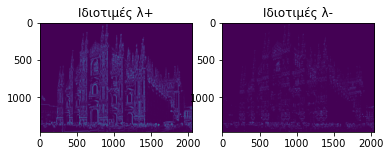

In [4]:
_,_,lsin,lmin = corner_detect_HS(cv2.imread('duomo_edges.jpg',0), 2,1.5,0.05,0.005)
plt.subplot(1,2,1)
plt.imshow(lsin[...,::-1])
plt.title('Ιδιοτιμές λ+')
plt.subplot(1,2,2)
plt.imshow(lmin[...,::-1])
plt.title('Ιδιοτιμές λ-')

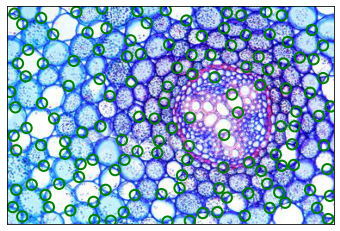

In [5]:
gg,p,_,_=corner_detect_HS(cv2.imread('cells.jpg',0), 2,1.5,0.05,0.005)
interest_points_visualization(cv2.imread('cells.jpg')[...,::-1],p) # [...,::-1] gia na fainontai swsta ta xrwmata RGB
#gg.shape
plt.savefig('corner_cells.jpg')

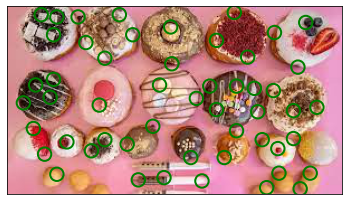

In [75]:
gg,p,_,_=corner_detect_HS(cv2.imread('donuts.jpg',0), 2,1.5,0.05,0.005)
interest_points_visualization(cv2.imread('donuts.jpg')[...,::-1],p) # [...,::-1] gia na fainontai swsta ta xrwmata RGB
#gg.shape
plt.savefig('corner_donuts.jpg')

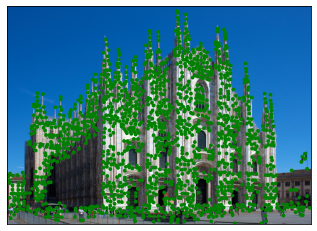

In [76]:
gg,p,_,_=corner_detect_HS(cv2.imread('duomo_edges.jpg',0), 2,1.5,0.05,0.005)
interest_points_visualization(cv2.imread('duomo_edges.jpg')[...,::-1],p) # [...,::-1] gia na fainontai swsta ta xrwmata RGB
#gg.shape
plt.savefig('corner_duomo.jpg')

# Multiscale Corner Detection Harris-Laplace

In [6]:
def corner_detect_HL(Img, sigma, s, p, k, theta_corn,N):
    #2.2.1
    sigmas = sigma * s**np.arange(0,N,1) #integral scale
    ps = p * s**np.arange(0,N,1)         #differential scale
    
    LoG = []
    for s_i in sigmas:
        n = int(2*np.ceil(3*s_i)+1)
        x, y = np.meshgrid(np.linspace(1,n,n),np.linspace(1,n,n))
        r = np.sqrt(x**2 + y**2)
        log_ = (np.exp((-r**2)/2*sigma**2))*(2-r**2/sigma**2)*2*np.pi*sigma**4
        
        LoG.append(cv2.filter2D(Img, -1, log_))
    
    n1, n2 = Img.shape 
   # n1-=20
   # n2-=20
    
    pixels = np.zeros((n1, n2, N))
    for i,j,n in zip(sigmas, ps, range(0, N)):
        a, _,_,_ = corner_detect_HS(Img, i, j, k, theta_corn)
        
        pixels[0:n1, 0:n2, n] = a.astype(bool)
    
    pixels_HL = np.array([0,0,0])
    
    for n_i in range(0, N):
        if n_i==0 and N>1:
            row, column = np.nonzero(((pixels[0:n1, 0:n2, n_i]).astype(bool) & (LoG[0] > LoG[1])))
            points = np.vstack((row,column,[sigmas[n_i]]*len(row))).T
            pixels_HL = np.vstack([pixels_HL, points])
            
        elif n_i==0 and N==1:
            row, column = np.nonzero(pixels[0:n1, 0:n2, n_i])
            points = np.vstack((row,column,[sigmas[n_i]]*len(row))).T
            pixels_HL = np.vstack([pixels_HL, points])
            
        elif n_i==N-1 and N>1:
            row, column = np.nonzero(((pixels[0:n1, 0:n2, n_i]).astype(bool) & (LoG[N-1] > LoG[N-2])))
            points = np.vstack((row,column,[sigmas[n_i]]*len(row))).T
            pixels_HL = np.vstack([pixels_HL, points])
            
        else:
            c1 = (LoG[n_i] > LoG[n_i-1]) & (LoG[n_i] > LoG[n_i+1])
            row, column = np.nonzero((pixels[0:n1, 0:n2, n_i]).astype(bool) & c1.astype(bool))
            points = np.vstack((row,column,[sigmas[n_i]]*len(row))).T
            pixels_HL = np.vstack([pixels_HL, points])
            
    return pixels_HL

<AxesSubplot:>

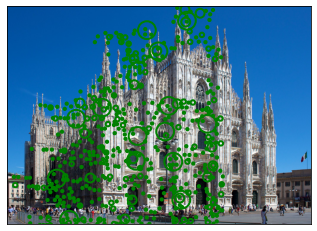

In [9]:
r=corner_detect_HL(cv2.imread('duomo_edges.jpg',0),2.5,2,1.5,0.05,0.005,4)
interest_points_visualization(cv2.imread('duomo_edges.jpg')[...,::-1],r)

# Blob Detection

In [10]:
def blob_detect(Img, sigma, theta_corn):
    
    ns = int(2*np.ceil(3*sigma)+1)
    gauss1Ds = cv2.getGaussianKernel(ns, sigma)
    gauss2Ds = gauss1Ds @ gauss1Ds.T
    Isigma = cv2.filter2D(Img,-1,gauss2Ds)
    
    Lx, Ly = np.gradient(Isigma)
    Lxx, Lxy = np.gradient(Lx)
    _, Lyy = np.gradient(Ly)
    
    R = abs(Lxx*Lyy - Lxy**2)
    
    B_sq = disk_strel(ns)
    Cond1 = (R == cv2.dilate(R,B_sq))
    Cond2 = (R > theta_corn * (np.max(R)))
    
    blobs_p = (Cond1 & Cond2).astype(int)
    row, column = np.nonzero(blobs_p)
    sigmas = sigma * np.ones(row.shape)
    blobs = np.vstack((column,row,sigmas)).T

    return blobs_p, blobs

<AxesSubplot:>

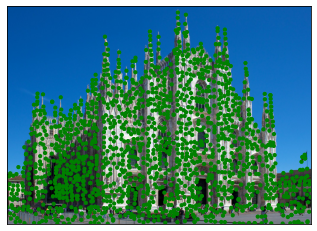

In [13]:
rr, blobs= blob_detect(cv2.imread('duomo_edges.jpg',0),2.5,0.005)
interest_points_visualization(cv2.imread('duomo_edges.jpg')[...,::-1],blobs)

# Multiscale Blob Detection

In [14]:
def blob_detect_ms(Img, sigma, s, theta_corn,N):
    
    sigmas = sigma * s**np.arange(0,N) #integral scale
    
    LoG = []
    for s_i in sigmas:
        n = int(2*np.ceil(3*s_i)+1)
        x, y = np.meshgrid(np.linspace(1,n,n),np.linspace(1,n,n))
        r = np.sqrt(x**2 + y**2)
        log_ = (np.exp((-r**2)/2*sigma**2))*(2-r**2/sigma**2)*2*np.pi*sigma**4
        
        LoG.append(cv2.filter2D(Img, -1, log_)) 
    
    n1, n2 = Img.shape
    
    pixels = np.zeros((n1, n2, N))
    for i,n in zip(sigmas,range(0, N)):
        a, _ = blob_detect(Img, i, theta_corn)
        
        pixels[0:n1, 0:n2, n] = a.astype(bool)
    
    blobs_m = np.array([0,0,0])
    
    for n_i in range(0, N):
        if n_i==0 and N>1:
            row, column = np.nonzero(((pixels[0:n1, 0:n2, n_i]).astype(bool) & (LoG[0] > LoG[1])))
            points = np.vstack((column,row,[sigmas[n_i]]*len(row))).T
            blobs_m = np.vstack([blobs_m, points])
            
        elif n_i==0 and N==1:
            row, column = np.nonzero(pixels[0:n1, 0:n2, n_i])
            points = np.vstack((column,row,[sigmas[n_i]]*len(row))).T
            blobs_m = np.vstack([blobs_m, points])
            
        elif n_i==N-1 and N>1:
            row, column = np.nonzero(((pixels[0:n1, 0:n2, n_i]).astype(bool) & (LoG[N-1] > LoG[N-2])))
            points = np.vstack((column,row,[sigmas[n_i]]*len(row))).T
            blobs_m = np.vstack([blobs_m, points])
        else:
            c1 = (LoG[n_i] > LoG[n_i-1]) & (LoG[n_i] > LoG[n_i+1])
            row, column = np.nonzero((pixels[0:n1, 0:n2, n_i]).astype(bool) & c1.astype(bool))
            points = np.vstack((column,row,[sigmas[n_i]]*len(row))).T
            blobs_m = np.vstack([blobs_m, points])
            
    return blobs_m

<AxesSubplot:>

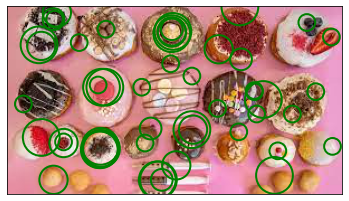

In [18]:
blobs_ms= blob_detect_ms(cv2.imread('donuts.jpg',0),2.5,1.3,0.005,4)
interest_points_visualization(cv2.imread('donuts.jpg')[...,::-1],blobs_ms)

# Box Filters

In [20]:
def box_filter_detect(Img, sigma, theta):
    
    n = int(2*np.ceil(3*sigma)+1)
    gauss1Ds = cv2.getGaussianKernel(n, sigma)
    gauss2Ds = gauss1Ds @ gauss1Ds.T
    Isigma = cv2.filter2D(Img,-1,gauss2Ds)
    I_integral = cv2.integral(Isigma)
    
    def IntFilter(img, n):
        N, M = img.shape
        
        Dxx = np.zeros((N,M))
        Dyy = np.zeros((N,M))
        Dxy = np.zeros((N,M))
        
        fl = int(np.floor(n/6))
        
        for i in range(0, N):
            for j in range(0, M):
                if (i-np.floor(n/6)*6-1 >= 0) and (j-np.floor(n/6)*6 -1 >= 0) and (i+np.floor(n/6)*6 +1  <= N-1) and (j+np.floor(n/6)*6 +1 <= M-1):
                    Dxx[i][j] = I_integral[i-2*fl][j-4*fl] - \
                                I_integral[i-2*fl][j-1*fl] - \
                                I_integral[i+3*fl][j-4*fl] + \
                                I_integral[i+3*fl][j-1*fl]
                                
                    Dxx[i][j] += (I_integral[i-2*fl][j-1*fl] - \
                                  I_integral[i-2*fl][j+2*fl] - \
                                  I_integral[i+3*fl][j-1*fl] + \
                                  I_integral[i+3*fl][j+2*fl]) * (-2)
                    
                    Dxx[i][j] += (I_integral[i-2*fl][j+2*fl] - \
                                  I_integral[i-2*fl][j+5*fl] - \
                                  I_integral[i+3*fl][j+2*fl] + \
                                  I_integral[i+3*fl][j+5*fl]) 
                    
                    Dyy[i][j] = I_integral[i-4*fl][j-2*fl] - \
                                I_integral[i-1*fl][j-2*fl] - \
                                I_integral[i-4*fl][j+3*fl] + \
                                I_integral[i-1*fl][j+3*fl]
                                
                    Dyy[i][j] += (I_integral[i-1*fl][j-2*fl] - \
                                  I_integral[i+2*fl][j-2*fl] - \
                                  I_integral[i-1*fl][j+3*fl] + \
                                  I_integral[i+2*fl][j+3*fl]) * (-2)
                    
                    Dyy[i][j] += (I_integral[i+2*fl][j-2*fl] - \
                                  I_integral[i+5*fl][j-2*fl] - \
                                  I_integral[i+2*fl][j+3*fl] + \
                                  I_integral[i+5*fl][j+3*fl])
                    
                    Dxy[i][j] = I_integral[i-3*fl][j-3*fl] - \
                                I_integral[i-3*fl][j] - \
                                I_integral[i][j-3*fl] + \
                                I_integral[i][j]
                                 
                    Dxy[i][j] += (I_integral[i-3*fl][j+1*fl] - \
                                 I_integral[i-3*fl][j+4*fl] - \
                                 I_integral[i][j+1*fl] + \
                                 I_integral[i][j+4*fl]) * (-1)
                    
                    Dxy[i][j] += (I_integral[i+1*fl][j-3*fl] - \
                                 I_integral[i+1*fl][j] - \
                                 I_integral[i+4*fl][j-3*fl] + \
                                 I_integral[i+4*fl][j]) * (-1)
                    
                    Dxy[i][j] += (I_integral[i+1*fl][j+1*fl] - \
                                 I_integral[i+1*fl][j+4*fl] - \
                                 I_integral[i+4*fl][j+1*fl] + \
                                 I_integral[i+4*fl][j+4*fl])
                    
        return Dxx, Dyy, Dxy
    
    
    Dxx, Dyy, Dxy = IntFilter(I_integral, n)
    
    R = Dxx*Dyy - 0.81*Dxy**2
    
    B_sq = disk_strel(n)
    Cond1 = (R==cv2.dilate(R,B_sq))
    Cond2 = (R > theta * np.max(R))
    
    pointss = (Cond1 & Cond2).astype(int)
    row, column = np.nonzero(pointss)
    sigmas = sigma * np.ones(row.shape)
    points = np.vstack((column,row,sigmas)).T

    
    return points,pointss,R

<AxesSubplot:>

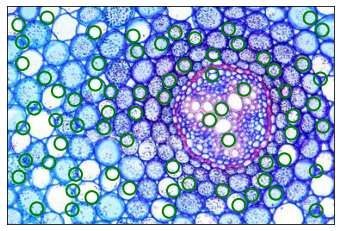

In [41]:
klkl,lo,rho=box_filter_detect(cv2.imread('cells.jpg',0), 2.5, 0.003)
interest_points_visualization(cv2.imread('cells.jpg')[...,::-1],klkl)

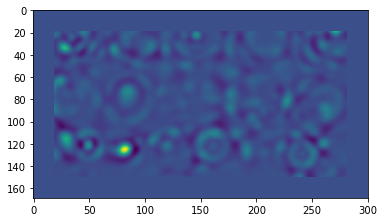

In [39]:
plt.imshow(rho)

In [44]:
def box_filter_ms(Img, sigma, s, theta_corn,N):
    
    sigmas = sigma * s**np.arange(0,N,1) #integral scale
    
    LoG = []
    for s_i in sigmas:
        n = int(2*np.ceil(3*s_i)+1)
        x, y = np.meshgrid(np.linspace(1,n,n),np.linspace(1,n,n))
        r = np.sqrt(x**2 + y**2)
        log_ = (np.exp((-r**2)/2*sigma**2))*(2-r**2/sigma**2)*2*np.pi*sigma**4
        
        LoG.append(cv2.filter2D(Img, -1, log_)) 
    
    n1, n2 = Img.shape
    
    pixels = np.zeros((n1+1, n2+1, N))
    for i,n in zip(sigmas,range(0, N)):
        _, a, _ = box_filter_detect(Img, i, theta_corn)
        
        pixels[0:n1+1, 0:n2+1, n] = a.astype(bool)
    
    box_ms = np.array([0,0,0])
    for n_i in range(0, N):
        if n_i==0 and N>1:
            row, column = np.nonzero(((pixels[0:n1, 0:n2, n_i]).astype(bool) & (LoG[0] > LoG[1])))
            points = np.vstack((column,row,[sigmas[n_i]]*len(row))).T
            box_ms = np.vstack([box_ms, points])
            
        elif n_i==0 and N==1:
            row, column = np.nonzero(pixels[0:n1, 0:n2, n_i])
            points = np.vstack((column,row,[sigmas[n_i]]*len(row))).T
            box_ms = np.vstack([box_ms, points])
            
        elif n_i==N-1 and N>1:
            row, column = np.nonzero(((pixels[0:n1, 0:n2, n_i]).astype(bool) & (LoG[N-1] > LoG[N-2])))
            points = np.vstack((column,row,[sigmas[n_i]]*len(row))).T
            box_ms = np.vstack([box_ms, points])
            
        else:
            c1 = (LoG[n_i] > LoG[n_i-1]) & (LoG[n_i] > LoG[n_i+1])
            row, column = np.nonzero((pixels[0:n1, 0:n2, n_i]).astype(bool) & c1.astype(bool))
            points = np.vstack((column,row,[sigmas[n_i]]*len(row))).T
            box_ms = np.vstack([box_ms, points])
            
    return box_ms

<AxesSubplot:>

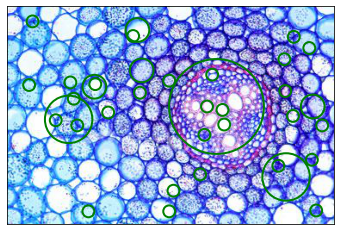

In [50]:
klkl2=box_filter_ms(cv2.imread('cells.jpg',0),2.3, 2, 0.05,4)
interest_points_visualization(cv2.imread('cells.jpg')[...,::-1],klkl2)